## Import libraries

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

Dataset complete info: https://archive.ics.uci.edu/ml/machine-learning-databases/car/

## Attribute Information:

Class Values:

unacc, acc, good, vgood

Attributes:

1. buying: vhigh, high, med, low.
2. maint: vhigh, high, med, low.
3. doors: 2, 3, 4, 5more.
4. persons: 2, 4, more.
5. lug_boot: small, med, big.
6. safety: low, med, high.





In [17]:
car_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"

In [18]:
#load to dataframe
columns =["buying","maint","doors","persons","lug_boot","safety","class"]
df = pd.read_csv(car_data, index_col=False, header=None, names=columns)

print('Original Dataset')
print(df.head())

# Since scikit-learn implementation does not support categorical variables for now
# we transform categorical variables (except the target) into one-hot encoding
df = pd.get_dummies(df,columns=df.columns.values[:-1])

#transform the target into numeric codes
labelencoder= LabelEncoder()
df["class"] = labelencoder.fit_transform(df["class"])

#inspect the head
print('\nProcessed Dataset')
print(df.head())



Original Dataset
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc

Processed Dataset
   class  buying_high  buying_low  buying_med  buying_vhigh  maint_high  \
0      2            0           0           0             1           0   
1      2            0           0           0             1           0   
2      2            0           0           0             1           0   
3      2            0           0           0             1           0   
4      2            0           0           0             1           0   

   maint_low  maint_med  maint_vhigh  doors_2  ...  doors_5more  persons_2  \
0          0          0            1        1  ...            0          1   
1          0          0            1   

## More preprocessing

In [23]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]

In [24]:
train_X, test_X, y_train, y_test = train_test_split(X,y,test_size=.2,stratify=y,random_state=0)

In [48]:
print("")
unique_v = y.sort_values().unique()
labels = labelencoder.inverse_transform(unique_v)
unique_v_labels = {k:v for k,v in zip(unique_v,labels)}

print(unique_v_labels)


{0: 'acc', 1: 'good', 2: 'unacc', 3: 'vgood'}


## Classification

In [30]:
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf = dt_clf.fit(train_X, y_train)

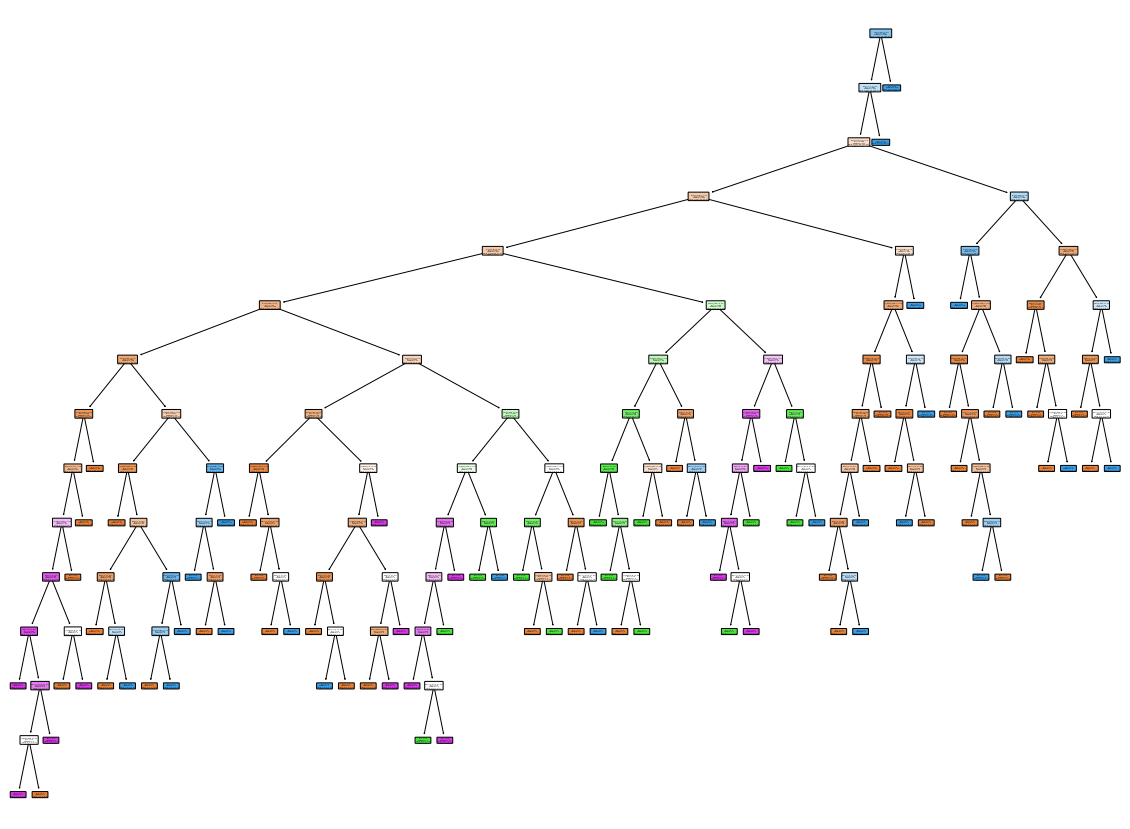

In [32]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 15))
plot_tree(dt_clf,
          filled=True,
          rounded=True,
          class_names=["unacc", "acc", "good", "vgood"],
         feature_names=X.columns);

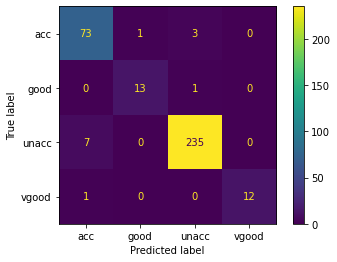

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

cf=ConfusionMatrixDisplay.from_estimator(dt_clf, test_X, y_test, display_labels=labels);

## Grid Search for best Parameters


In [69]:
param_grid = {'criterion':['gini','entropy'],\
    'max_depth':[2,3,4,5,6,7,8,9,10,11,12,15,20],\
        }
        
decisionTreeClassifier = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(decisionTreeClassifier, param_grid, cv=10)
gs = gs.fit(train_X, y_train)

print("Best estimator found by grid search:")
model = gs.best_estimator_
print(model)


Best estimator found by grid search:
DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=0)



## Compute Accuracy


In [67]:

Train_pred_y = gs.predict(train_X)
Test_pred_y = gs.predict(test_X)

print('Train Accuracy {:0.2f}%'.format( (y_train == Train_pred_y).mean()*100 ))
print('Test Accuracy {:0.2f}%'.format( (y_test == Test_pred_y).mean()*100 ))


Train Accuracy 99.71%
Test Accuracy 96.53%


## Effect of Criterion and Max_depth on accuracy

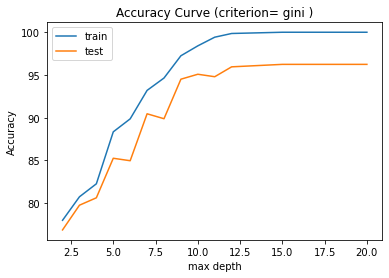

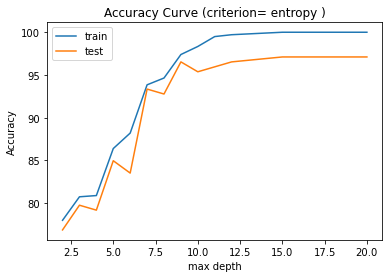

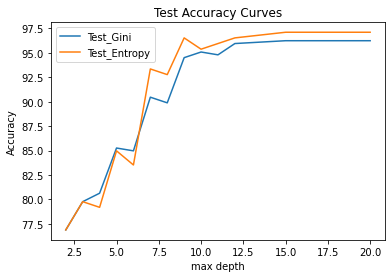

In [82]:
Test_pred_criterion = []
for c in param_grid["criterion"]:
    Train_pred_y,Test_pred_y,max_depth_d = [], [], []
    for d in param_grid["max_depth"]:
        dtc = DecisionTreeClassifier(random_state=0,criterion=c,max_depth=d).fit(train_X, y_train)
        Train_pred = dtc.predict(train_X)
        Test_pred = dtc.predict(test_X)
        Train_pred_y.append(  (y_train == Train_pred).mean()*100 )
        Test_pred_y.append( (y_test == Test_pred).mean()*100 )
        max_depth_d.append(d)
    Test_pred_criterion.append(Test_pred_y)
    # #make plot
    plt.figure()
    plt.plot(max_depth_d,Train_pred_y,label='train')
    plt.plot(max_depth_d,Test_pred_y,label='test')
    plt.xlabel('max depth')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve (criterion= '+c+" )")
    plt.legend()

plt.figure()
for test_c,c in zip(Test_pred_criterion,param_grid["criterion"]):
    #make plot
    plt.plot(max_depth_d,test_c,label='Test_'+c.capitalize())
    plt.xlabel('max depth')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Curves')
    plt.legend()

## Notes

1. Entropy returns better accuracy than Gini after a certain maximum depth (here about max_depth=7)
2. Both train and test accuracies improves until certain maximum depth  
(here about max_depth=12 as rightly returned by the gridsearch) beyound which no more improvement was recorded.